<a href="https://colab.research.google.com/github/Juan-Clay/NLP_a1/blob/main/assignment1final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import tensorflow as tf
import numpy as np
import tensorflow as tf

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from itertools import product
import random


In [2]:
tf.random.set_seed(1234)
np.random.seed(1234)

In [3]:
print("Loading IMDB dataset...")
# Load the IMDB reviews dataset with the 'as_supervised' flag so that we get (text, label) pairs.
(ds_train, ds_test), ds_info = tfds.load('imdb_reviews',
                                           split=['train', 'test'],
                                           as_supervised=True,
                                           with_info=True)
print("Done1")

Loading IMDB dataset...
Done1


In [14]:
# -------------------------------
# Character-Level Tokenizer and Preprocessing Functions
# -------------------------------
def char_level_tokenizer(texts, num_words=None):
    """
    Create and fit a character-level tokenizer.

    Args:
        texts (list of str): List of texts (e.g., movie reviews).
        num_words (int or None): Maximum number of tokens to keep (based on frequency).

    Returns:
        tokenizer: A fitted Tokenizer instance.
    """
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words, char_level=True, lower=True)
    tokenizer.fit_on_texts(texts)
    return tokenizer

def texts_to_bow(tokenizer, texts):
    """
    Convert texts to a bag-of-characters representation.

    Args:
        tokenizer: A fitted character-level Tokenizer.
        texts (list of str): List of texts.

    Returns:
        Numpy array representing binary presence of characters.
    """
    # Use texts_to_matrix with mode 'binary' to create fixed-length vectors.
    matrix = tokenizer.texts_to_matrix(texts, mode='binary')
    return matrix
def one_hot_encode(labels, num_classes=2):
    """
    Convert numeric labels to one-hot encoded vectors.
    """
    return np.eye(num_classes)[labels]

In [7]:
# Convert training dataset to lists.
train_texts = []
train_labels = []
for text, label in tfds.as_numpy(ds_train):
    # Decode byte strings to utf-8 strings.
    train_texts.append(text.decode('utf-8'))
    train_labels.append(label)
train_labels = np.array(train_labels)

# Create a validation set from the training data (20% for validation).
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42)

# Convert test dataset to lists.
test_texts = []
test_labels = []
for text, label in tfds.as_numpy(ds_test):
    test_texts.append(text.decode('utf-8'))
    test_labels.append(label)
test_labels = np.array(test_labels)

print(f"Train samples: {len(train_texts)}, Validation samples: {len(val_texts)}, Test samples: {len(test_texts)}")



Train samples: 20000, Validation samples: 5000, Test samples: 25000


In [20]:
tokenizer_char = char_level_tokenizer(train_texts)
print("Tokenizer vocabulary size:", len(tokenizer_char.word_index) + 1)
char_vocab_size = len(tokenizer_char.word_index) + 1

Tokenizer vocabulary size: 134


In [22]:
char_seq_lengths = [len(seq) for seq in tokenizer_char.texts_to_sequences(train_texts)]
print(f"Average Character-Level Sequence Length: {np.mean(char_seq_lengths):.2f}")

Average Character-Level Sequence Length: 1326.28


In [16]:
# Convert texts to bag-of-characters representation.
X_train = texts_to_bow(tokenizer_char, train_texts)
X_val   = texts_to_bow(tokenizer_char, val_texts)
X_test  = texts_to_bow(tokenizer_char, test_texts)

# Convert labels to one-hot encoding.
y_train = one_hot_encode(train_labels)
y_val   = one_hot_encode(val_labels)
y_test  = one_hot_encode(test_labels)


In [4]:
class MLP(object):
    def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
        """
        size_input: int, size of input layer
        size_hidden1: int, size of the 1st hidden layer
        size_hidden2: int, size of the 2nd hidden layer
        size_hidden3: int, size of the 3rd hidden layer (not used in compute_output here)
        size_output: int, size of output layer
        device: str or None, either 'cpu' or 'gpu' or None.
        """
        self.size_input = size_input
        self.size_hidden1 = size_hidden1
        self.size_hidden2 = size_hidden2
        self.size_hidden3 = size_hidden3  # (Currently not used in the forward pass)
        self.size_output = size_output
        self.device = device

        # Initialize weights and biases for first hidden layer
        self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1], stddev=0.1))
        self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1]))

        # Initialize weights and biases for second hidden layer
        self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2], stddev=0.1))
        self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))

        # Initialize weights and biases for output layer
        self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_output], stddev=0.1))
        self.b3 = tf.Variable(tf.zeros([1, self.size_output]))

        # List of variables to update during backpropagation
        self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]

    def forward(self, X):
        """
        Forward pass.
        X: Tensor, inputs.
        """
        if self.device is not None:
            with tf.device('gpu:0' if self.device == 'gpu' else 'cpu'):
                self.y = self.compute_output(X)
        else:
            self.y = self.compute_output(X)
        return self.y

    def loss(self, y_pred, y_true):
        """
        Computes the loss between predicted and true outputs.
        y_pred: Tensor of shape (batch_size, size_output)
        y_true: Tensor of shape (batch_size, size_output)
        """
        y_true_tf = tf.cast(y_true, dtype=tf.float32)
        y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
        cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        loss_x = cce(y_true_tf, y_pred_tf)
        return loss_x

    def backward(self, X_train, y_train):
        """
        Backward pass: compute gradients of the loss with respect to the variables.
        """
        with tf.GradientTape() as tape:
            predicted = self.forward(X_train)
            current_loss = self.loss(predicted, y_train)
        grads = tape.gradient(current_loss, self.variables)
        return grads

    def compute_output(self, X):
        """
        Custom method to compute the output tensor during the forward pass.
        """
        # Cast X to float32
        X_tf = tf.cast(X, dtype=tf.float32)
        # First hidden layer
        h1 = tf.matmul(X_tf, self.W1) + self.b1
        z1 = tf.nn.relu(h1)
        # Second hidden layer
        h2 = tf.matmul(z1, self.W2) + self.b2
        z2 = tf.nn.relu(h2)
        # Output layer (logits)
        output = tf.matmul(z2, self.W3) + self.b3
        return output

In [17]:
# -------------------------------
# Model Setup
# -------------------------------
# The input size is determined by the dimension of the bag-of-characters vector.
size_input = X_train.shape[1]

# Set hidden layer sizes as desired.
size_hidden1 = 128
size_hidden2 = 64
size_hidden3 = 32  # Placeholder (not used in the forward pass)
size_output  = 2

# Instantiate the MLP model.
model = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None)

# Define the optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# -------------------------------
# Training Parameters and Loop
# -------------------------------
batch_size = 128
epochs = 10
num_batches = int(np.ceil(X_train.shape[0] / batch_size))

print("\nStarting training...\n")
for epoch in range(epochs):
    # Shuffle training data at the start of each epoch.
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train = X_train[indices]
    y_train = y_train[indices]

    epoch_loss = 0
    for i in range(num_batches):
        start = i * batch_size
        end = min((i+1) * batch_size, X_train.shape[0])
        X_batch = X_train[start:end]
        y_batch = y_train[start:end]

        # Compute gradients and update weights.
        # with tf.GradientTape() as tape:
        #     predictions = model.forward(X_batch)
        #     loss_value = model.loss(predictions, y_batch)
        # grads = tape.gradient(loss_value, model.variables)
        predictions = model.forward(X_batch)
        loss_value = model.loss(predictions, y_batch)
        grads = model.backward(X_batch, y_batch)
        optimizer.apply_gradients(zip(grads, model.variables))
        epoch_loss += loss_value.numpy() * (end - start)

    epoch_loss /= X_train.shape[0]

    # Evaluate on validation set.
    val_logits = model.forward(X_val)
    val_loss = model.loss(val_logits, y_val).numpy()
    val_preds = np.argmax(val_logits.numpy(), axis=1)
    true_val = np.argmax(y_val, axis=1)
    accuracy = np.mean(val_preds == true_val)
    precision = precision_score(true_val, val_preds)
    recall = recall_score(true_val, val_preds)

    print(f"Epoch {epoch+1:02d} | Training Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

# -------------------------------
# Final Evaluation on Test Set
# -------------------------------
print("\nEvaluating on test set...")
test_logits = model.forward(X_test)
test_loss = model.loss(test_logits, y_test).numpy()
test_preds = np.argmax(test_logits.numpy(), axis=1)
true_test = np.argmax(y_test, axis=1)
test_accuracy = np.mean(test_preds == true_test)
test_precision = precision_score(true_test, test_preds)
test_recall = recall_score(true_test, test_preds)

print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f} | "
      f"Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f}")



Starting training...

Epoch 01 | Training Loss: 0.6708 | Val Loss: 0.6625 | Accuracy: 0.6102 | Precision: 0.5880 | Recall: 0.6547
Epoch 02 | Training Loss: 0.6613 | Val Loss: 0.6622 | Accuracy: 0.6034 | Precision: 0.5799 | Recall: 0.6601
Epoch 03 | Training Loss: 0.6601 | Val Loss: 0.6603 | Accuracy: 0.6182 | Precision: 0.5885 | Recall: 0.7067
Epoch 04 | Training Loss: 0.6569 | Val Loss: 0.6589 | Accuracy: 0.6104 | Precision: 0.5863 | Recall: 0.6671
Epoch 05 | Training Loss: 0.6575 | Val Loss: 0.6611 | Accuracy: 0.6080 | Precision: 0.6147 | Recall: 0.5128
Epoch 06 | Training Loss: 0.6533 | Val Loss: 0.6605 | Accuracy: 0.6016 | Precision: 0.5721 | Recall: 0.7067
Epoch 07 | Training Loss: 0.6509 | Val Loss: 0.6568 | Accuracy: 0.6122 | Precision: 0.5966 | Recall: 0.6180
Epoch 08 | Training Loss: 0.6468 | Val Loss: 0.6565 | Accuracy: 0.6102 | Precision: 0.5877 | Recall: 0.6568
Epoch 09 | Training Loss: 0.6446 | Val Loss: 0.6584 | Accuracy: 0.6104 | Precision: 0.5985 | Recall: 0.5965
Epoch

In [9]:
# -------------------------------
# Changing to Word-Level Tokenizer and Preprocessing Functions
# -------------------------------
def word_level_tokenizer(texts, num_words=10000):  # Limit vocabulary to 10,000 words
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words, lower=True)
    tokenizer.fit_on_texts(texts)
    return tokenizer

def word_texts_to_bow(tokenizer, texts):
    matrix = tokenizer.texts_to_matrix(texts, mode='count')
    return matrix

def one_hot_encode(labels, num_classes=2):
    """
    Convert numeric labels to one-hot encoded vectors.
    """
    return np.eye(num_classes)[labels]

In [21]:
tokenizer_word = word_level_tokenizer(train_texts)
print("Tokenizer vocabulary size:", len(tokenizer_word.word_index) + 1)
word_vocab_size = len(tokenizer_word.word_index) + 1

Tokenizer vocabulary size: 80169


In [23]:
word_seq_lengths = [len(seq) for seq in tokenizer_word.texts_to_sequences(train_texts)]
print(f"Average Word-Level Sequence Length: {np.mean(word_seq_lengths):.2f}")

Average Word-Level Sequence Length: 224.21


In [11]:
# Convert texts to bag-of-characters representation.
X_train = word_texts_to_bow(tokenizer_word, train_texts)
X_val   = word_texts_to_bow(tokenizer_word, val_texts)
X_test  = word_texts_to_bow(tokenizer_word, test_texts)

# Convert labels to one-hot encoding.
y_train = one_hot_encode(train_labels)
y_val   = one_hot_encode(val_labels)
y_test  = one_hot_encode(test_labels)


In [12]:
print("New input size:", X_train.shape[1])


New input size: 10000


In [13]:
# -------------------------------
# Model Setup
# -------------------------------
# The input size is determined by the dimension of the bag-of-characters vector.
size_input = X_train.shape[1]
# Set hidden layer sizes as desired.
size_hidden1 = 128
size_hidden2 = 64
size_hidden3 = 32  # Placeholder (not used in the forward pass)
size_output  = 2

# Instantiate the MLP model.
model = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None)

# Define the optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)  #adaptive optimization


# -------------------------------
# Training Parameters and Loop
# -------------------------------
batch_size = 128
epochs = 10
num_batches = int(np.ceil(X_train.shape[0] / batch_size))

print("\nStarting training...\n")
for epoch in range(epochs):
    # Shuffle training data at the start of each epoch.
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train = X_train[indices]
    y_train = y_train[indices]

    epoch_loss = 0
    for i in range(num_batches):
        start = i * batch_size
        end = min((i+1) * batch_size, X_train.shape[0])
        X_batch = X_train[start:end]
        y_batch = y_train[start:end]

        # Compute gradients and update weights.
        # with tf.GradientTape() as tape:
        #     predictions = model.forward(X_batch)
        #     loss_value = model.loss(predictions, y_batch)
        # grads = tape.gradient(loss_value, model.variables)
        predictions = model.forward(X_batch)
        loss_value = model.loss(predictions, y_batch)
        grads = model.backward(X_batch, y_batch)
        optimizer.apply_gradients(zip(grads, model.variables))
        epoch_loss += loss_value.numpy() * (end - start)

    epoch_loss /= X_train.shape[0]

    # Evaluate on validation set.
    val_logits = model.forward(X_val)
    val_loss = model.loss(val_logits, y_val).numpy()
    val_preds = np.argmax(val_logits.numpy(), axis=1)
    true_val = np.argmax(y_val, axis=1)
    accuracy = np.mean(val_preds == true_val)
    precision = precision_score(true_val, val_preds)
    recall = recall_score(true_val, val_preds)

    print(f"Epoch {epoch+1:02d} | Training Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

# -------------------------------
# Final Evaluation on Test Set
# -------------------------------
print("\nEvaluating on test set...")
test_logits = model.forward(X_test)
test_loss = model.loss(test_logits, y_test).numpy()
test_preds = np.argmax(test_logits.numpy(), axis=1)
true_test = np.argmax(y_test, axis=1)
test_accuracy = np.mean(test_preds == true_test)
test_precision = precision_score(true_test, test_preds)
test_recall = recall_score(true_test, test_preds)

print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f} | "
      f"Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f}")


Starting training...

Epoch 01 | Training Loss: 0.4464 | Val Loss: 0.3479 | Accuracy: 0.8596 | Precision: 0.9159 | Recall: 0.7822
Epoch 02 | Training Loss: 0.2003 | Val Loss: 0.3259 | Accuracy: 0.8758 | Precision: 0.8303 | Recall: 0.9348
Epoch 03 | Training Loss: 0.0914 | Val Loss: 0.3731 | Accuracy: 0.8816 | Precision: 0.8779 | Recall: 0.8779
Epoch 04 | Training Loss: 0.0301 | Val Loss: 0.4905 | Accuracy: 0.8744 | Precision: 0.8748 | Recall: 0.8647
Epoch 05 | Training Loss: 0.0080 | Val Loss: 0.6071 | Accuracy: 0.8784 | Precision: 0.8709 | Recall: 0.8795
Epoch 06 | Training Loss: 0.0021 | Val Loss: 0.6954 | Accuracy: 0.8762 | Precision: 0.8609 | Recall: 0.8882
Epoch 07 | Training Loss: 0.0010 | Val Loss: 0.7549 | Accuracy: 0.8750 | Precision: 0.8554 | Recall: 0.8932
Epoch 08 | Training Loss: 0.0006 | Val Loss: 0.7950 | Accuracy: 0.8756 | Precision: 0.8556 | Recall: 0.8944
Epoch 09 | Training Loss: 0.0004 | Val Loss: 0.8246 | Accuracy: 0.8762 | Precision: 0.8641 | Recall: 0.8837
Epoch

In [24]:
print("Comparison of Tokenization Approaches:\n")
print(f"Character-Level Vocabulary Size: {char_vocab_size}")
print(f"Word-Level Vocabulary Size: {word_vocab_size}")
print(f"Average Character-Level Sequence Length: {np.mean(char_seq_lengths):.2f}")
print(f"Average Word-Level Sequence Length: {np.mean(word_seq_lengths):.2f}")

Comparison of Tokenization Approaches:

Character-Level Vocabulary Size: 134
Word-Level Vocabulary Size: 80169
Average Character-Level Sequence Length: 1326.28
Average Word-Level Sequence Length: 224.21


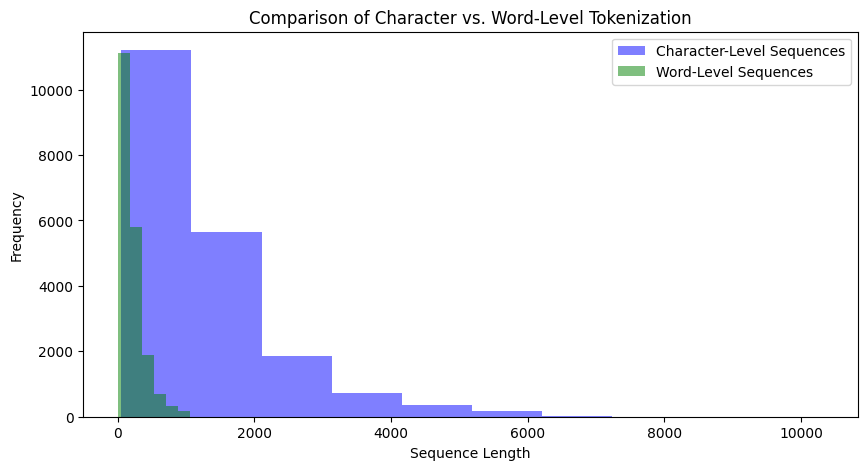

In [25]:
plt.figure(figsize=(10,5))
plt.hist(char_seq_lengths, bins=10, alpha=0.5, label='Character-Level Sequences', color='blue')
plt.hist(word_seq_lengths, bins=10, alpha=0.5, label='Word-Level Sequences', color='green')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.legend()
plt.title('Comparison of Character vs. Word-Level Tokenization')
plt.show()

In [26]:
#Develop a model (or models) that can handle both tokenization types. Include the following adjustable hyper-parameters:

In [29]:
def create_model(vocab_size,
                 embedding_dim=128,
                 num_hidden_layers=2,
                 hidden_size=64,
                 activation='relu',
                 optimizer_choice='adam',
                 learning_rate=0.001):


    model = tf.keras.Sequential()

    # Embedding layer
    model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True))
    model.add(tf.keras.layers.GlobalAveragePooling1D())

    #Hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(hidden_size, activation=activation))

    # Output Layer with 2 neurons for one-hot encoding
    model.add(tf.keras.layers.Dense(2, activation='softmax'))  # 2 neurons for binary classification

    # Choose optimizr
    if optimizer_choice.lower() == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_choice.lower() == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer_choice.lower() == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer. Choose from ['adam', 'sgd', 'rmsprop']")

    #use categorical_crossentropy for one-hot encoding
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model


In [30]:
model = create_model(vocab_size=5000, num_hidden_layers=2, hidden_size=128, activation='relu', optimizer_choice='adam')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.5007 - loss: 0.6938 - val_accuracy: 0.4945 - val_loss: 0.6932
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5009 - loss: 0.6933 - val_accuracy: 0.5055 - val_loss: 0.6931
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.4919 - loss: 0.6933 - val_accuracy: 0.4945 - val_loss: 0.6933
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5008 - loss: 0.6933 - val_accuracy: 0.5055 - val_loss: 0.6931
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.5026 - loss: 0.6932 - val_accuracy: 0.5055 - val_loss: 0.6931
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5018 - loss: 0.6932 - val_accuracy: 0.5055 - val_loss: 0.6931
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5021 - loss: 0.6932 - val_accuracy: 0.5055 - val_loss: 0.6931
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5021 - loss: 0.6932 - val_ac

In [37]:
param_grid = {
    "learning_rate": [0.001, 0.0005, 0.0001],
    "hidden_layers": [1, 2, 3],
    "hidden_size": [128, 256, 512],
    "batch_size": [32, 64, 128],
    "optimizer": ["adam", "sgd", "rmsprop"],
    "activation": ["relu", "tanh", "leaky_relu"]
}

param_combinations = list(product(*param_grid.values()))

In [34]:
def run_experiment(config, num_trials=3):

    learning_rate = config["learning_rate"]
    hidden_layers = config["hidden_layers"]
    hidden_size = config["hidden_size"]
    batch_size = config["batch_size"]
    optimizer_choice = config["optimizer"]
    activation = config["activation"]

    accuracies, losses = [], []

    for _ in range(num_trials):
        # Create model
        model = create_model(vocab_size=5000,
                             embedding_dim=128,
                             num_hidden_layers=hidden_layers,
                             hidden_size=hidden_size,
                             activation=activation,
                             optimizer_choice=optimizer_choice,
                             learning_rate=learning_rate)

        # Train model
        history = model.fit(X_train, y_train,
                            epochs=5,  # Reduce epochs for faster experimentation
                            batch_size=batch_size,
                            validation_data=(X_val, y_val),
                            verbose=0)  # Suppress output

        # Get last epoch results
        final_loss, final_acc = model.evaluate(X_val, y_val, verbose=0)
        losses.append(final_loss)
        accuracies.append(final_acc)

    return {
        "config": config,
        "avg_loss": np.mean(losses),
        "avg_accuracy": np.mean(accuracies)
    }

In [36]:
random_configs = random.sample(param_combinations, 50)

results = []

for config in random_configs:
    config_dict = dict(zip(param_grid.keys(), config))
    print(f"Testing configuration: {config_dict}")
    result = run_experiment(config_dict)
    results.append(result)

# Convert results to a DataFrame
df_results = pd.DataFrame(results)
df_results.to_csv("hyperparameter_results_random.csv", index=False)
print("Saved results to hyperparameter_results_random.csv")

Testing configuration: {'learning_rate': 0.0005, 'hidden_layers': 3, 'hidden_size': 128, 'batch_size': 128, 'optimizer': 'sgd', 'activation': 'leaky_relu'}
Testing configuration: {'learning_rate': 0.0001, 'hidden_layers': 3, 'hidden_size': 512, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'leaky_relu'}
Testing configuration: {'learning_rate': 0.0005, 'hidden_layers': 2, 'hidden_size': 512, 'batch_size': 128, 'optimizer': 'adam', 'activation': 'relu'}
Testing configuration: {'learning_rate': 0.0001, 'hidden_layers': 1, 'hidden_size': 256, 'batch_size': 64, 'optimizer': 'sgd', 'activation': 'relu'}
Testing configuration: {'learning_rate': 0.0001, 'hidden_layers': 1, 'hidden_size': 128, 'batch_size': 32, 'optimizer': 'sgd', 'activation': 'leaky_relu'}
Testing configuration: {'learning_rate': 0.001, 'hidden_layers': 3, 'hidden_size': 128, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}
Testing configuration: {'learning_rate': 0.001, 'hidden_layers': 3, 'hidden_si

Highest performing configuration had:

{'learning_rate': 0.0001, 'hidden_layers': 1, 'hidden_size': 128, 'batch_size': 32, 'optimizer': 'sgd', 'activation': 'leaky_relu'}	With about 50 percent accuracy